| Chỉ số                  | Ý nghĩa                                                                 | Khi nào dùng                              | Ghi chú                              |
|-------------------------|-------------------------------------------------------------------------|-------------------------------------------|--------------------------------------|
| **Silhouette Score**    | Đo mức độ gần gũi của điểm với cụm của nó so với cụm gần nhất khác       | Luôn dùng để đánh giá chất lượng phân cụm  | Giá trị [-1, 1], cao hơn thì tốt     |
| **Number of Clusters**  | Số lượng cụm được tạo ra bởi thuật toán                                 | Luôn theo dõi để đảm bảo phù hợp bài toán  | Kiểm tra dựa trên kiến thức miền     |
| **Calinski-Harabasz Score** | Đo tỷ lệ giữa độ phân tán giữa các cụm và trong cụm                  | Dùng khi cần đánh giá sự tách biệt cụm     | Giá trị cao hơn thì tốt              |
| **Davies-Bouldin Score** | Đo mức độ tương đồng giữa các cụm dựa trên khoảng cách và kích thước   | Dùng khi cần đánh giá tính đồng đều cụm    | Giá trị thấp hơn thì tốt             |

# Khai báo thư viện

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# ------------------------------------------------------------------
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ------------------------------------------------------------------
from scipy.stats import uniform
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# ------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
# ------------------------------------------------------------------
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score
from sklearn.metrics import make_scorer, silhouette_samples
# ------------------------------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from joblib import Parallel, delayed
import optuna
from optuna.pruners import MedianPruner

# Data

In [3]:
df = pd.read_csv("D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Mall Customers\Mall_Customers_preprocessed.csv")

In [4]:
df.head()

,customerid,age,annual_income,spending_score,genre_Female
0,1,-1.424569,-1.738999,-0.434801,0.0
1,2,-1.281035,-1.738999,1.195704,0.0
2,3,-1.352802,-1.700830,-1.715913,1.0
3,4,-1.137502,-1.700830,1.040418,1.0
4,5,-0.563369,-1.662660,-0.395980,1.0


In [5]:
data = df.drop(columns=["customerid"],axis=1,)

In [6]:
X = data.copy()
X.head()

,age,annual_income,spending_score,genre_Female
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0


# Áp Dụng

## AP

### 1. Tham số thuật toán

```
preference
damping
```
=> Tập trung tối ưu vào damping và preference

In [ ]:
ap = AffinityPropagation(random_state=42, damping=0.7, preference=-70.470)
ap.fit(X)

AffinityPropagation(damping=0.7, preference=-70.47, random_state=42)

### 2. Biểu diễn phân cụm

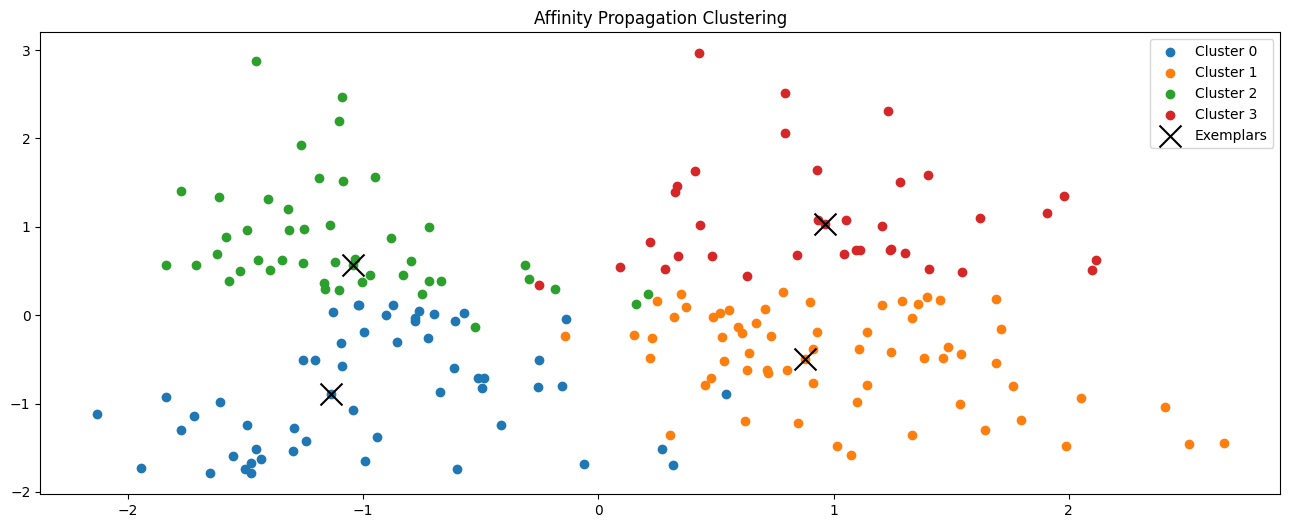

In [8]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Hyperparameter Optimization

### 1. Grid Search

In [9]:
# Không gian tìm kiếm
param_grid = {
    "damping": np.linspace(0.5, 0.9, 5),
    "preference": np.linspace(-300, 0, 150),
}

grid = ParameterGrid(param_grid)
top_results = []

for params in grid:
    model = AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=42
    )
    
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        continue

    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    top_results.append({
        "params": params,
        "sil_score": sil_score,
        "dbi": db_score,
        "chi": ch_score,
        "n_clusters": n_clusters,
        "labels": labels,
        "model": model
    })

In [10]:
top_results = sorted(top_results, key=lambda x: x["sil_score"], reverse=True)[:5]  # Lấy kết quả tốt nhất
show_results = pd.DataFrame(columns=["Top","Silhouette","Davies-Bouldin","Calinski-Harabaz","Số cụm","Damping","Preference",])
for i, res in enumerate(top_results):
    show_results.loc[len(show_results)] = [
        i + 1,
        round(res["sil_score"],3),
        round(res["dbi"],3),
        round(res["chi"],3),
        round(res["n_clusters"],3),
        round(res["params"]["damping"],3),
        round(res["params"]["preference"],3),
    ]
show_results

,Top,Silhouette,Davies-Bouldin,Calinski-Harabaz,Số cụm,Damping,Preference
0,1.0,0.371,0.882,76.514,26.0,0.7,-2.013
1,2.0,0.371,0.882,76.514,26.0,0.8,-2.013
2,3.0,0.371,0.882,76.514,26.0,0.9,-2.013
3,4.0,0.367,0.871,76.916,28.0,0.5,-2.013
4,5.0,0.367,0.871,76.916,28.0,0.6,-2.013


### 2. Optuna

|Tính năng | Ý nghĩa |
|---|---|
|Sơ đồ dòng tối ưu hóa | Hiểu tổng quan quá trình|
|Early Stopping (Pruning) | Tiết kiệm thời gian|
|Visualization | Nhìn thấy quá trình tối ưu trực quan|

In [11]:
# Không gian tìm kiếm
damping_values = np.linspace(0.5, 0.9, 5)
preference_values = np.linspace(-300, 0, 150)

# Lưu kết quả tốt nhất
top_results = []


def objective(trial):
    damping = trial.suggest_categorical("damping", damping_values.tolist())
    preference = trial.suggest_categorical("preference", preference_values.tolist())

    model = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        trial.report(0.0, step=0)
        raise optuna.exceptions.TrialPruned()

    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    trial.report(sil_score, step=0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    top_results.append(
        {
            "params": {"damping": damping, "preference": preference},
            "sil_score": sil_score,
            "dbi": db_score,
            "chi": ch_score,
            "n_clusters": n_clusters,
            "labels": labels,
            "model": model,
        }
    )

    return sil_score

In [12]:
# Tạo Study có pruner
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=0)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100)

[I 2025-05-07 19:53:59,440] A new study created in memory with name: no-name-c135c94a-fa02-489b-a5d8-de3a9f05ef24
[I 2025-05-07 19:53:59,459] Trial 0 finished with value: 0.31138752942367165 and parameters: {'damping': 0.7, 'preference': -20.13422818791946}. Best is trial 0 with value: 0.31138752942367165.
[I 2025-05-07 19:53:59,483] Trial 1 finished with value: 0.34650887941342307 and parameters: {'damping': 0.5, 'preference': -56.37583892617448}. Best is trial 0 with value: 0.31138752942367165.
[I 2025-05-07 19:53:59,497] Trial 2 pruned. 
[I 2025-05-07 19:53:59,506] Trial 3 pruned. 
[I 2025-05-07 19:53:59,522] Trial 4 pruned. 
[I 2025-05-07 19:53:59,538] Trial 5 finished with value: 0.29173694026218283 and parameters: {'damping': 0.6, 'preference': -207.38255033557044}. Best is trial 5 with value: 0.29173694026218283.
[I 2025-05-07 19:53:59,550] Trial 6 finished with value: 0.3674819229714247 and parameters: {'damping': 0.5, 'preference': -2.0134228187919234}. Best is trial 5 with va

In [13]:
# Vẽ lịch sử tối ưu (Optimization History)
optuna.visualization.plot_optimization_history(study).show()

In [14]:
# Vẽ tầm quan trọng của các tham số
optuna.visualization.plot_param_importances(study).show()

In [15]:
top_results = sorted(top_results, key=lambda x: x["sil_score"], reverse=True)[:5]  # Lấy kết quả tốt nhất
show_results = pd.DataFrame(columns=["Top","Silhouette","Davies-Bouldin","Calinski-Harabaz","Số cụm","Damping","Preference",])
for i, res in enumerate(top_results):
    show_results.loc[len(show_results)] = [
        i + 1,
        round(res["sil_score"],3),
        round(res["dbi"],3),
        round(res["chi"],3),
        round(res["n_clusters"],3),
        round(res["params"]["damping"],3),
        round(res["params"]["preference"],3),
    ]
show_results

,Top,Silhouette,Davies-Bouldin,Calinski-Harabaz,Số cụm,Damping,Preference
0,1.0,0.367,0.871,76.916,28.0,0.5,-2.013
1,2.0,0.347,1.084,98.204,4.0,0.5,-56.376
2,3.0,0.311,1.205,84.555,8.0,0.7,-20.134
3,4.0,0.303,1.263,88.666,5.0,0.9,-54.362
4,5.0,0.297,1.269,77.685,10.0,0.6,-14.094


### 3. Hyperopt

In [23]:
# Không gian tìm kiếm
damping_values = np.linspace(0.5, 0.9, 5)
preference_values = np.linspace(-300, 0, 150)

space = {
    "index": hp.choice(
        "index", list(range(len(damping_values) * len(preference_values)))
    )
}

top_results = []


# Hàm mục tiêu
def objective(params):
    global top_results

    index = params["index"]
    damping_index = index // len(preference_values)
    preference_index = index % len(preference_values)

    damping = damping_values[damping_index]
    preference = preference_values[preference_index]

    model = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    # Loại bỏ trường hợp không hợp lệ
    if n_clusters <= 1 or n_clusters >= len(X):
        return {"loss": 1, "status": STATUS_OK}

    # Tính các chỉ số đánh giá
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    # Lưu kết quả nếu đủ tốt
    result = {
        "loss": -sil_score,
        "status": STATUS_OK,
        "params": {"damping": damping, "preference": preference},
        "sil_score": sil_score,
        "dbi": db_score,
        "chi": ch_score,
        "n_clusters": n_clusters,
        "labels": labels.tolist(),
    }

    top_results.append(result)

    return result

In [24]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

100%|██████████| 200/200 [00:06<00:00, 31.70trial/s, best loss: -0.3708617942108482]


In [ ]:
top_results = sorted(top_results, key=lambda x: x["sil_score"], reverse=True)[:5]  # Lấy kết quả tốt nhất
show_results = pd.DataFrame(columns=["Top","Silhouette","Davies-Bouldin","Calinski-Harabaz","Số cụm","Damping","Preference",])
for i, res in enumerate(top_results):
    show_results.loc[len(show_results)] = [
        i + 1,
        round(res["sil_score"],3),
        round(res["dbi"],3),
        round(res["chi"],3),
        round(res["n_clusters"],3),
        round(res["params"]["damping"],3),
        round(res["params"]["preference"],3),
    ]
show_results

,Top,Silhouette,Davies-Bouldin,Calinski-Harabaz,Số cụm,Damping,Preference
0,1.0,0.371,0.882,76.514,26.0,0.7,-2.013
1,2.0,0.371,0.882,76.514,26.0,0.7,-2.013
2,3.0,0.371,0.882,76.514,26.0,0.7,-2.013
3,4.0,0.371,0.882,76.514,26.0,0.7,-2.013
4,5.0,0.371,0.882,76.514,26.0,0.7,-2.013


# Một số kết luận

Tiêu chí | Grid Search | Hyperopt / Optuna
---|---|---
Cách tìm kiếm | Quét toàn bộ (mọi tổ hợp parameter có thể) | Tối ưu hóa thông minh dựa trên mẫu ngẫu nhiên + học từ kết quả trước
Phủ không gian tham số | Đảm bảo mọi vùng đều được quét qua | Không đảm bảo quét hết — ưu tiên vùng thấy "ngon" sớm
Phụ thuộc random | Không | Có
Độ tin cậy khi mẫu nhỏ | Cao (vì bao phủ đều) | Thấp (dễ mắc kẹt vào vùng xấu)

<p>

Grid Search | Hyperopt / Optuna
---|---
Tin cậy hơn khi số lượng trial nhỏ | Cần nhiều trial mới hiệu quả
Tìm chắc chắn preference tốt | Dễ tìm nhầm preference xấu
Độ ổn định cao | Độ dao động lớn

**Vì vậy**:
- Grid Search: Khi ít mẫu và không gian nhỏ, nó rất hiệu quả vì đi hết từng ngóc ngách.
- Hyperopt / Optuna: Cần nhiều lượt thử mới "học" được vùng tốt vì khi ít trial thì hay bị chọn nhầm vùng xấu.